<a href="https://colab.research.google.com/github/Caizhenxin/Neuromatch/blob/main/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Sequential Probability Ratio Test

**Week 3, Day 2: Hidden Dynamics**

**By Neuromatch Academy**

**Content creators:** Yicheng Fei and Xaq Pitkow

**Content reviewers:** John Butler, Matt Krause, Spiros Chavlis, Melvin Selim Atay, Keith van Antwerp, Michael Waskom, Jesse Livezey, and Byron Galbraith

**Production Editor:** Ella Batty, Gagana B, Spiros Chavlis

---
# Tutorial Objectives

*Estimated timing of tutorial: 45 minutes*

On Bayes Day, we learned how to combine the sensory measurement $m$ about a latent variable $s$ with our prior knowledge, using Bayes' Theorem. This produced a posterior probability distribution $p(s|m)$. Today we will allow for _dynamic_ world states and measurements.

In Tutorial 1 we will assume that the world state is _binary_ ($\pm 1$) and _constant_ over time, but allow for multiple observations over time. We will use the *Sequential Probability Ratio Test* (SPRT) to infer which state is true. This leads to the *Drift Diffusion Model (DDM)* where evidence accumulates until reaching a stopping criterion.

By the end of this tutorial, you should be able to:
- Define and implement the Sequential Probability Ratio Test for a series of measurements
- Define what drift and diffusion mean in a drift-diffusion model
- Explain the speed-accuracy trade-off in a drift diffusion model

**Summary of Exercises**

0. Bonus (math): derive the Drift Diffusion Model mathematically from SPRT

1. Simulate the DDM
    1. _Code_: Accumulate evidence and make a decision (DDM)
    2. _Interactive_: Manipulate parameters and interpret

2. Analyze the DDM
    1. _Code_: Quantify speed-accuracy tradeoff
    2. _Interactive_: Manipulate parameters and interpret

In [1]:
# @title Tutorial slides
# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
link_id = "jdwfz"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/jdwfz/


---
# Setup

In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W3D2_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.7 MB/s eta 0:00:00


In [3]:
# Imports
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import erf

In [4]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracy_analytical_list, accuracy_list=None):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    stop_time_list (int): List of number of steps to run before stopping.
    accuracy_analytical_list (int): List of analytical accuracies for each stop time
    accuracy_list (int (optional)): List of simulated accuracies for each stop time
  """
  T = stop_time_list[-1]
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_xlabel('Stop Time')
  ax.set_ylabel('Average Accuracy')
  ax.plot(stop_time_list, accuracy_analytical_list)
  if accuracy_list is not None:
    ax.plot(stop_time_list, accuracy_list)
  ax.legend(['analytical','simulated'], loc='upper center')

  # Show two gaussian
  stop_time_list_plot = [max(1,T//10), T*2//3]
  sigma_st_max = 2*mu*np.sqrt(stop_time_list_plot[-1])/sigma
  domain = np.linspace(-3*sigma_st_max,3*sigma_st_max,50)
  for stop_time in stop_time_list_plot:
    ins = ax.inset_axes([stop_time/T,0.05,0.2,0.3])
    for pos in ['right', 'top', 'bottom', 'left']:
      ins.spines[pos].set_visible(False)
    ins.axis('off')
    ins.set_title(f"stop_time={stop_time}")

    left = np.zeros_like(domain)
    mu_st = 4*mu*mu*stop_time/2/sigma**2
    sigma_st = 2*mu*np.sqrt(stop_time)/sigma
    for i, mu1 in enumerate([-mu_st,mu_st]):
      rv = stats.norm(mu1, sigma_st)
      offset = rv.pdf(domain)
      lbl = "summed evidence" if i == 1 else ""
      color = "crimson"
      ls = "solid" if i==1 else "dashed"
      ins.plot(domain, left+offset, label=lbl, color=color,ls=ls)

    rv = stats.norm(mu_st, sigma_st)
    domain0 = np.linspace(-3*sigma_st_max,0,50)
    offset = rv.pdf(domain0)
    ins.fill_between(domain0, np.zeros_like(domain0), offset, color="crimson", label="error")
    ins.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

  plt.show(fig)

In [6]:
# @title Helper Functions

def simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample,
                                     verbose=True):
  """Simulate and plot a SPRT for a fixed amount of time given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    stop_time (int): Number of steps to run before stopping.
    num_sample (int): The number of samples to plot.
    """

  evidence_history_list = []
  if verbose:
    print("Trial\tTotal_Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, Mvec = simulate_SPRT_fixedtime(mu, sigma, stop_time)
    if verbose:
      print("{}\t{:f}\t{}".format(i, evidence_history[-1], decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.zeros(maxlen_evidence), '--', c='red', alpha=1.0)
  for evidences in evidence_history_list:
    ax.plot(np.arange(len(evidences)), evidences)
    ax.set_xlabel("Time")
    ax.set_ylabel("Accumulated log likelihood ratio")
    ax.set_title("Log likelihood ratio trajectories under the fixed-time " +
                  "stopping rule")

  plt.show(fig)


def simulate_and_plot_SPRT_fixedthreshold(mu, sigma, num_sample, alpha,
                                          verbose=True):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    num_sample (int): The number of samples to plot.
    alpha (float): Threshold for making a decision.
  """
  # calculate evidence threshold from error rate
  threshold = threshold_from_errorrate(alpha)

  # run simulation
  evidence_history_list = []
  if verbose:
    print("Trial\tTime\tAccumulated Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, Mvec = simulate_SPRT_threshold(mu, sigma, threshold)
    if verbose:
      print("{}\t{}\t{:f}\t{}".format(i, len(Mvec), evidence_history[-1],
                                      decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(-np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(np.zeros(maxlen_evidence + 1), '--', c='red', alpha=0.5)

  for evidences in evidence_history_list:
      ax.plot(np.arange(len(evidences) + 1), np.concatenate([[0], evidences]))

  ax.set_xlabel("Time")
  ax.set_ylabel("Accumulated log likelihood ratio")
  ax.set_title("Log likelihood ratio trajectories under the threshold rule")

  plt.show(fig)


def simulate_and_plot_accuracy_vs_threshold(mu, sigma, threshold_list, num_sample):
  """Simulate and plot a SPRT for a set of thresholds given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    alpha_list (float): List of thresholds for making a decision.
    num_sample (int): The number of samples to plot.
  """
  accuracies, decision_speeds = simulate_accuracy_vs_threshold(mu, sigma,
                                                               threshold_list,
                                                               num_sample)

  # Plotting
  fig, ax = plt.subplots()
  ax.plot(decision_speeds, accuracies, linestyle="--", marker="o")
  ax.plot([np.amin(decision_speeds), np.amax(decision_speeds)],
          [0.5, 0.5], c='red')
  ax.set_xlabel("Average Decision speed")
  ax.set_ylabel('Average Accuracy')
  ax.set_title("Speed/Accuracy Tradeoff")
  ax.set_ylim(0.45, 1.05)

  plt.show(fig)


def threshold_from_errorrate(alpha):
  """Calculate log likelihood ratio threshold from desired error rate `alpha`

  Args:
    alpha (float): in (0,1), the desired error rate

  Return:
    threshold: corresponding evidence threshold
  """
  threshold = np.log((1. - alpha) / alpha)
  return threshold

---
# Section 0: Overview of tutorials

In [7]:
# @title Video 1: Overview of Tutorials on Hidden Dynamics
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'HH7HkQ1kv5M'), ('Bilibili', 'BV1Eh411r7hm')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [8]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Overview_of_Tutorials_Video")

---

# Section 1: Sequential Probability Ratio Test as a Drift Diffusion Model

*Estimated timing to here from start of tutorial: 8 min*

In [9]:
# @title Video 2: Sequential Probability Ratio Test
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'vv0yukRSTT0'), ('Bilibili', 'BV1Yo4y1D7Be')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

This video covers the definition of and math behind the sequential probability ratio test (SPRT), and introduces the idea of the SPRT as a drift diffusion model.

<details>
<summary><font color='blue'>Click here for text recap of video</font>
</summary>

**Sequential Probability Ratio Test**

The Sequential Probability Ratio Test is a likelihood ratio test for determining which of two hypotheses is more likely. It is appropriate for sequential independent and identically distributed (iid) data. iid means that the data comes from the same distribution.

Let's return to what we learned yesterday. We had probabilities of our measurement ($m$) given a state of the world ($s$). For example, we knew the probability of seeing someone catch a fish while fishing on the left side given that the fish were on the left side $P(m = \textrm{catch fish} | s = \textrm{left})$.

Now let's extend this slightly to assume we take a series of measurements, from time 1 up to time t ($m_{1:t}$), and that our state is either +1 or -1. We want to figure out what the state is, given our measurements. To do this, we can compare the total evidence up to time $t$ for our two hypotheses (that the state is +1 or that the state is -1). We do this by computing a likelihood ratio: the ratio of the likelihood of all these measurements given the state is +1, $p(m_{1:t}|s=+1)$, to the likelihood of the measurements given the state is -1, $p(m_{1:t}|s=-1)$. This is our likelihood ratio test. In fact, we want to take the log of this likelihood ratio to give us the log likelihood ratio $L_T$.

\begin{align*}
L_T &= log\frac{p(m_{1:t}|s=+1)}{p(m_{1:t}|s=-1)}
\end{align*}

Since our data is independent and identically distribution, the probability of all measurements given the state equals the product of the separate probabilities of each measurement given the state ($p(m_{1:t}|s) = \prod_{t=1}^T p(m_t | s) $). We can substitute this in and use log properties to convert to a sum.

\begin{align*}
L_T &= log\frac{p(m_{1:t}|s=+1)}{p(m_{1:t}|s=-1)}\\
&= log\frac{\prod_{t=1}^Tp(m_{t}|s=+1)}{\prod_{t=1}^Tp(m_{t}|s=-1)}\\
&= \sum_{t=1}^T log\frac{p(m_{t}|s=+1)}{p(m_{t}|s=-1)}\\
&= \sum_{t=1}^T \Delta_t
\end{align*}

In the last line, we have used $\Delta_t = log\frac{p(m_{t}|s=+1)}{p(m_{t}|s=-1)}$.

To get the full log likelihood ratio, we are summing up the log likelihood ratios at each time step. The log likelihood ratio at a time step ($L_T$) will equal the ratio at the previous time step ($L_{T-1}$) plus the ratio for the measurement at that time step, given by $\Delta_T$:

\begin{align*}
L_T =  L_{T-1} + \Delta_T
\end{align*}

The SPRT states that if $L_T$ is positive, then the state $s=+1$ is more likely than $s=-1$!


**Sequential Probability Ratio Test as a Drift Diffusion Model**

Let's assume that the probability of seeing a measurement given the state is a Gaussian (Normal) distribution where the mean ($\mu$) is different for the two states but the standard deviation ($\sigma$) is the same:

\begin{align*}
p(m_t | s = +1) &= \mathcal{N}(\mu, \sigma^2)\\
p(m_t | s = -1) &= \mathcal{N}(-\mu, \sigma^2)\\
\end{align*}

We can write the new evidence (the log likelihood ratio for the measurement at time $t$) as

$$\Delta_t=b+c\epsilon_t$$

The first term, $b$, is a consistent value and equals $b=2\mu^2/\sigma^2$. This term favors the actual hidden state. The second term, $c\epsilon_t$ where $\epsilon_t\sim\mathcal{N}(0,1)$, is a standard random variable which is scaled by the diffusion $c=2\mu/\sigma$. You can work through proving this in the bonus exercise 0 below if you wish!

The accumulation of evidence will thus "drift" toward one outcome, while "diffusing" in random directions, hence the term "drift-diffusion model" (DDM). The process is most likely (but not guaranteed) to reach the correct outcome eventually.


</details>

In [10]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Sequential_Probability_Ratio_Test_Video")

<details>
<summary><font color='blue'>Bonus math exercise 0: derive Drift Diffusion Model from SPRT</font>
</summary>

We can do a little math to find the SPRT update $\Delta_t$ to the log-likelihood ratio. You can derive this yourself, filling in the steps below, or skip to the end result.

Assume measurements are Gaussian-distributed with different means depending on the discrete latent variable $s$:

\begin{equation}
p(m|s=\pm 1) = \mathcal{N}\left(\mu_\pm,\sigma^2\right)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left[-\frac{(m-\mu_\pm)^2}{2\sigma^2}\right]}
\end{equation}

In the log likelihood ratio for a single data point $m_i$, the normalizations cancel to give

\begin{equation}
\Delta_t=\log \frac{p(m_t|s=+1)}{p(m_t|s=-1)} = \frac{1}{2\sigma^2}\left[-\left(m_t-\mu_+\right)^2 + (m_t-\mu_-)^2\right] \tag{5}
\end{equation}

It's convenient to rewrite $m=\mu_\pm + \sigma \epsilon$, where $\epsilon\sim \mathcal{N}(0,1)$ is a standard Gaussian variable with zero mean and unit variance. (Why does this give the correct probability for $m$?). The preceding formula can then be rewritten as
$$\Delta_t = \frac{1}{2\sigma^2}\left( -((\mu_\pm+\sigma\epsilon)-\mu_+)^2 + ((\mu_\pm+\sigma\epsilon)-\mu_-)^2\right) \tag{5}$$
Let's assume that $s=+1$ so $\mu_\pm=\mu_+$ (if $s=-1$ then the result is the same with a reversed sign). In that case, the means in the first term $m_t-\mu_+$ cancel, leaving

\begin{equation}
\Delta_t = \frac{\delta^2\mu^2}{2\sigma^2}+\frac{\delta\mu}{\sigma}\epsilon_t \tag{5}
\end{equation}

where $\delta\mu=\mu_+-\mu_-$. If we take $\mu_\pm=\pm\mu$, then $\delta\mu=2\mu$, and

\begin{equation}
\Delta_t=2\frac{\mu^2}{\sigma^2}+2\frac{\mu}{\sigma}\epsilon_t
\end{equation}

The first term is a constant *drift*, and the second term is a random *diffusion*.

The SPRT says that we should add up these evidences, $L_T=\sum_{t=1}^T \Delta_t$. Note that the $\Delta_t$ are independent. Recall that for independent random variables, the mean of a sum is the sum of the means. And the variance of a sum is the sum of the variances.

</details>

Adding these $\Delta_t$ over time gives

\begin{equation}
L_T\sim\mathcal{N}\left(2\frac{\mu^2}{\sigma^2}T,\ 4\frac{\mu^2}{\sigma^2}T\right)=\mathcal{N}(bT,c^2T)
\end{equation}

as claimed. The log-likelihood ratio $L_t$ is a biased random walk --- normally distributed with a time-dependent mean and variance. This is the **Drift Diffusion Model**.

##  Coding Exercise 1.1: Simulating an SPRT model

Let's now generate simulated data with $s=+1$ and see if the SPRT can infer the state correctly.

We will implement a function `simulate_SPRT_fixedtime`, which will generate measurements based on $\mu$, $\sigma$, and the true state. It will then accumulate evidence over the time steps and output a decision on the state. The decision will be the state that is more likely according to the accumulated evidence. We will use the helper function `log_likelihood_ratio`, implemented in the next cell, which computes the log of the likelihood of the state being 1 divided by the likelihood of the state being -1.

**Your coding tasks are:**

**Step 1**: accumulate evidence.

**Step 2**: make a decision at the last time point.

We will then visualize 10 simulations of the DDM. In the next exercise you'll see how the parameters affect performance.


In [11]:
# @markdown Execute this cell to enable the helper function `log_likelihood_ratio`

def log_likelihood_ratio(Mvec, p0, p1):
  """Given a sequence(vector) of observed data, calculate the log of
  likelihood ratio of p1 and p0

  Args:
    Mvec (numpy vector):           A vector of scalar measurements
    p0 (Gaussian random variable): A normal random variable with `logpdf'
                                    method
    p1 (Gaussian random variable): A normal random variable with `logpdf`
                                    method

  Returns:
    llvec: a vector of log likelihood ratios for each input data point
  """
  return p1.logpdf(Mvec) - p0.logpdf(Mvec)

Trial	Total_Evidence	Decision
0	-1.825211	-1.0
1	3.033974	1.0
2	1.121418	1.0
3	1.978989	1.0
4	-0.699630	-1.0
5	1.214701	1.0
6	0.773329	1.0
7	0.727977	1.0
8	2.286441	1.0
9	2.611457	1.0


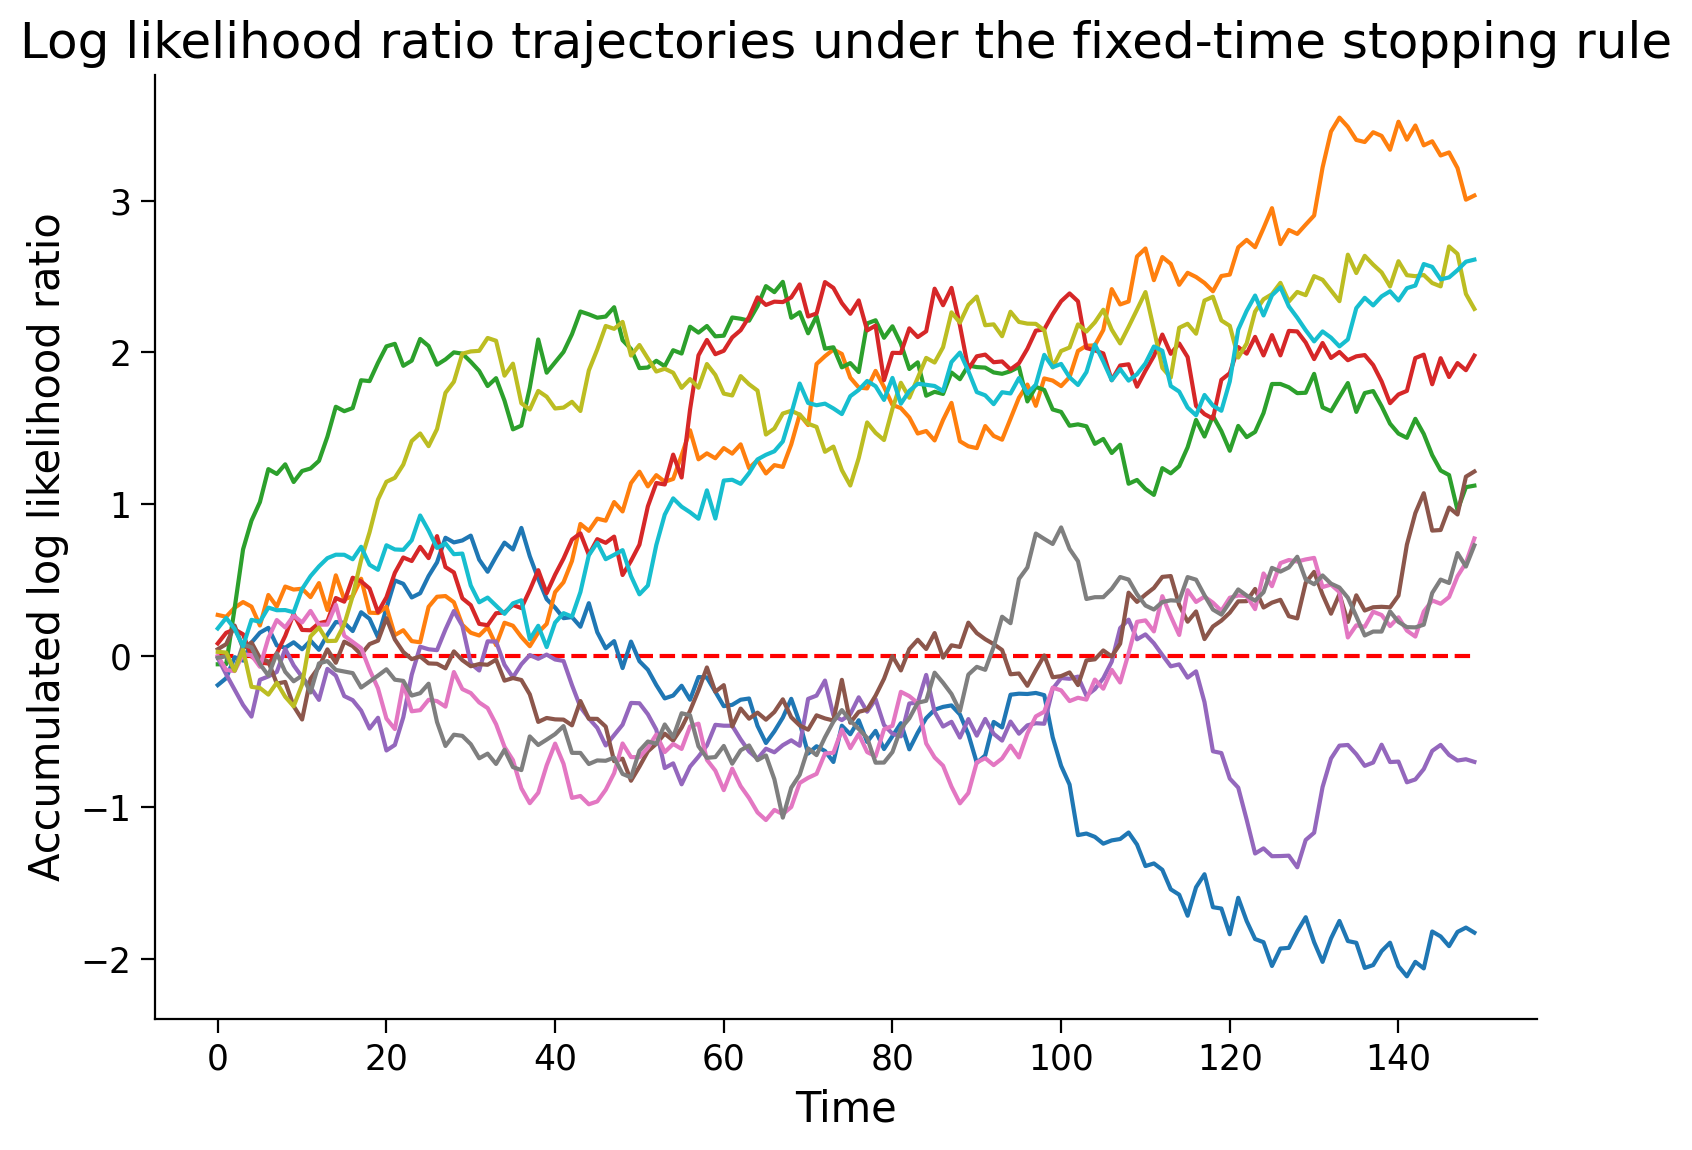

In [13]:
def simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist = 1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of observation models
    stop_time (int): Number of samples to take before stopping
    true_dist (1 or -1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for s = 1, -1 for s = -1
    Mvec (numpy vector): the generated sequences of measurement data in this trial
  """

  #################################################
  ## TODO for students ##
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete simulate_SPRT_fixedtime")
  #################################################

  # Set means of observation distributions
  assert mu > 0, "Mu should be > 0"
  mu_pos = mu
  mu_neg = -mu

  # Make observation distributions
  p_pos = stats.norm(loc = mu_pos, scale = sigma)
  p_neg = stats.norm(loc = mu_neg, scale = sigma)

  # Generate a random sequence of measurements
  if true_dist == 1:
    Mvec = p_pos.rvs(size = stop_time)
  else:
    Mvec = p_neg.rvs(size = stop_time)

  # Calculate log likelihood ratio for each measurement (delta_t)
  ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

  # STEP 1: Calculate accumulated evidence (S) given a time series of evidence (hint: np.cumsum)
  evidence_history = np.cumsum(ll_ratio_vec)

  # STEP 2: Make decision based on the sign of the evidence at the final time.
  decision = np.sign(evidence_history[-1])

  return evidence_history, decision, Mvec


# Set random seed
np.random.seed(100)

# Set model parameters
mu = .2
sigma = 3.5  # standard deviation for p+ and p-
num_sample = 10  # number of simulations to run
stop_time = 150 # number of steps before stopping

# Simulate and visualize
simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_985833af.py)

*Example output:*

<img alt='Solution hint' align='left' width=812.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_985833af_1.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Simulating_an_SPRT_model_Exercise")

## Interactive Demo 1.2: Trajectories under the fixed-time stopping rule


In the following demo, you can change the drift level (mu), noise level (sigma) in the observation model and the number of time steps before stopping (stop_time) using the sliders. You will then observe 10 simulations with those parameters. As in the previous exercise, the true state is +1.



1.   Are you more likely to make the wrong decision (choose the incorrect state) with high or low noise?
2. What happens when sigma is very small? Why?
3.   Are you more likely to make the wrong decision (choose the incorrect state) with fewer or more time steps before stopping?





In [14]:
# @markdown Make sure you execute this cell to enable the widget!

def simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist=1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of observation models
    stop_time (int): Number of samples to take before stopping
    true_dist (1 or -1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for s = 1, -1 for s = -1
    Mvec (numpy vector): the generated sequences of measurement data in this trial
  """

  # Set means of observation distributions
  assert mu > 0, "Mu should be >0"
  mu_pos = mu
  mu_neg = -mu

  # Make observation distributions
  p_pos = stats.norm(loc = mu_pos, scale = sigma)
  p_neg = stats.norm(loc = mu_neg, scale = sigma)

  # Generate a random sequence of measurements
  if true_dist == 1:
    Mvec = p_pos.rvs(size = stop_time)
  else:
    Mvec = p_neg.rvs(size = stop_time)

  # Calculate log likelihood ratio for each measurement (delta_t)
  ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

  # STEP 1: Calculate accumulated evidence (S) given a time series of evidence (hint: np.cumsum)
  evidence_history = np.cumsum(ll_ratio_vec)

  # STEP 2: Make decision based on the sign of the evidence at the final time.
  decision = np.sign(evidence_history[-1])

  return evidence_history, decision, Mvec


np.random.seed(100)
num_sample = 10

@widgets.interact(mu=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5),
                  sigma=(0.05, 10.0, 0.05), stop_time=(5, 500, 1))
def plot(mu, sigma, stop_time):
  simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time,
                                   num_sample, verbose=False)

interactive(children=(FloatSlider(value=0.5, description='mu', max=5.0, min=0.1), FloatSlider(value=5.0, descr…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_0b020b9a.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Trajectories_under_the_fixed_time_stopping rule_Interactive_Demo_and_Discussion")

In [ ]:
# @title Video 3: Section 1 Exercises Discussion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'P6xuOS5TB7Q'), ('Bilibili', 'BV1h54y1E7UC')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_1_Exercises_Discussion_Video")

---
# Section 2: Analyzing the DDM: accuracy vs stopping time

*Estimated timing to here from start of tutorial: 28 min*

In [ ]:
# @title Video 4: Speed vs Accuracy Tradeoff
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Hc3uXQiKvZA'), ('Bilibili', 'BV1s54y1E7yT')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Speed_vs_Accuracy_Tradeoff_Video")

If you make a hasty decision (e.g., after only seeing 2 samples), or if observation noise buries the signal, you may see a negative accumulated log likelihood ratio and thus make a wrong decision. Let's plot how decision accuracy varies with the number of samples. Accuracy is the proportion of correct trials across our repeated simulations: $\frac{\# \textrm{ correct decisions}}{\# \textrm{ total decisions}}$.





### Coding Exercise 2.1: The Speed/Accuracy Tradeoff

We will fix our observation noise level. In this exercise you will implement a function to run many simulations for a certain stopping time, and calculate the _average decision accuracy_. We will then visualize the relation between average decision accuracy and stopping time.

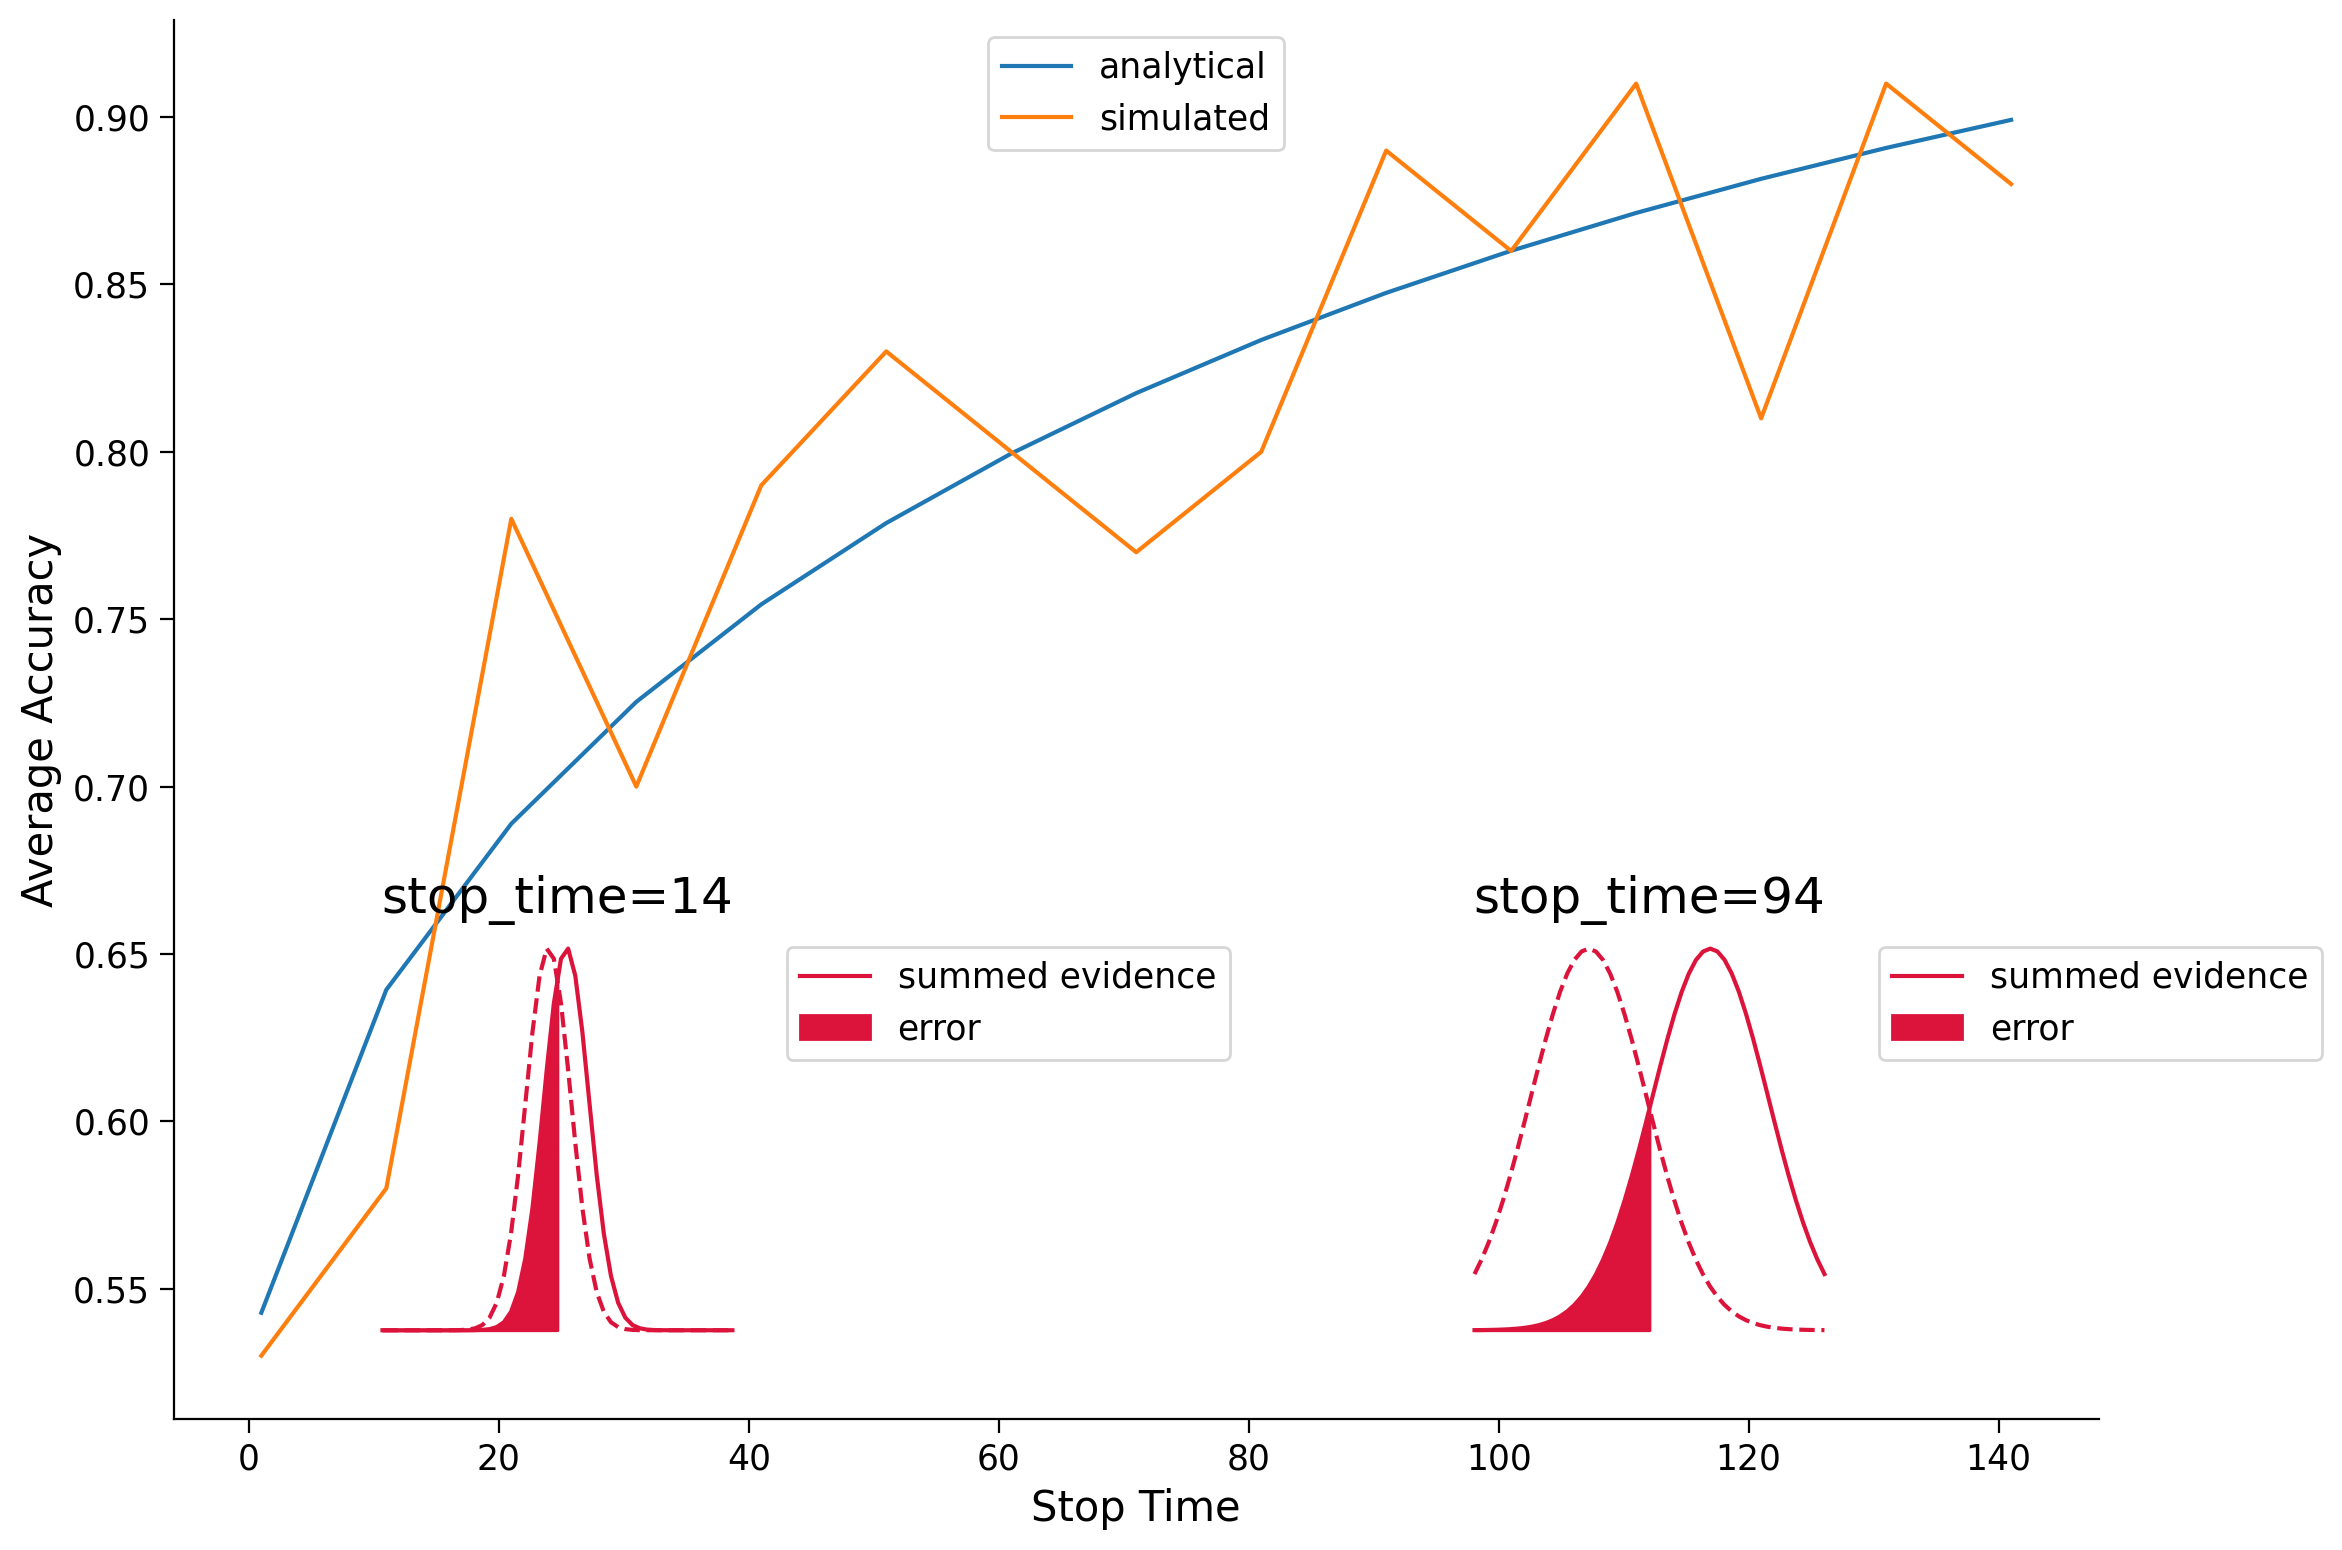

In [15]:
def simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list, num_sample,
                                  no_numerical=False):
  """Calculate the average decision accuracy vs. stopping time by running
  repeated SPRT simulations for each stop time.

  Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): standard deviation for observation model
      stop_list_list (list-like object): a list of stopping times to run over
      num_sample (int): number of simulations to run per stopping time
      no_numerical (bool): flag that indicates the function to return analytical values only

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `stop_time_list`
      decisions_list: a list of decisions made in all trials
  """

  #################################################
  ## TODO for students##
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete simulate_accuracy_vs_stoptime")
  #################################################

  # Determine true state (1 or -1)
  true_dist = 1

  # Set up tracker of accuracy and decisions
  accuracies = np.zeros(len(stop_time_list),)
  accuracies_analytical = np.zeros(len(stop_time_list),)
  decisions_list = []

  # Loop over stop times
  for i_stop_time, stop_time in enumerate(stop_time_list):

    if not no_numerical:
      # Set up tracker of decisions for this stop time
      decisions = np.zeros((num_sample,))

      # Loop over samples
      for i in range(num_sample):

        # STEP 1: Simulate run for this stop time (hint: use output from last exercise)
        _, decision, _= simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist)

        # Log decision
        decisions[i] = decision

      # STEP 2: Calculate accuracy by averaging over trials
      accuracies[i_stop_time] = np.sum(decisions == true_dist) / decisions.shape[0]

      # Log decision
      decisions_list.append(decisions)

    # Calculate analytical accuracy
    sigma_sum_gaussian = sigma / np.sqrt(stop_time)
    accuracies_analytical[i_stop_time] = 0.5 + 0.5 * erf(mu / np.sqrt(2) / sigma_sum_gaussian)

  return accuracies, accuracies_analytical, decisions_list


# Set random seed
np.random.seed(100)

# Set parameters of model
mu = 0.5
sigma = 4.65  # standard deviation for observation noise
num_sample = 100  # number of simulations to run for each stopping time
stop_time_list = np.arange(1, 150, 10) # Array of stopping times to use


# Calculate accuracies for each stop time
accuracies, accuracies_analytical, _ = simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list,
                                                   num_sample)

# Visualize
plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracies_analytical, accuracies)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_59bd207a.py)

*Example output:*

<img alt='Solution hint' align='left' width=1171.0 height=778.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_59bd207a_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Speed_vs_Accuracy_Tradeoff_Exercise")

In the figure above, we are plotting the simulated accuracies in orange. We can actually find an analytical equation for the average accuracy in this specific case, which we plot in blue. We will not dive into this analytical solution here but you can imagine that if you ran a bunch of different simulations and had the equivalent number of orange lines, the average of those would resemble the blue line.

In the insets, we are showing the evidence distributions for the two states at a certain time point. Recall from Section 1 that the likelihood ratio at time $T$ for state of +1 is:

\begin{equation}
L_T\sim\mathcal{N}\left(2\frac{\mu^2}{\sigma^2}T,\ 4\frac{\mu^2}{\sigma^2}T\right)=\mathcal{N}(bT,c^2T)
\end{equation}

If the state is -1, the mean is the reverse sign. We are plotting this Gaussian distribution for the state equaling -1 (dashed line) and the state equaling +1 (solid line). The area in red reflects the error rate - this region corresponds to $L_T$ being below 0 even though the true state is +1 so you would decide on the wrong state. As more time goes by, these distributions separate more and the error is lower.

### Interactive Demo 2.2: Accuracy versus stop-time

For this same visualization, now vary the mean $\mu$ and standard deviation `sigma` of the evidence. What do you predict will the accuracy vs stopping time plot look like for low noise and high noise?

In [16]:
# @markdown Make sure you execute this cell to enable the widget!

def simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list,
                                  num_sample, no_numerical=False):
  """Calculate the average decision accuracy vs. stopping time by running
  repeated SPRT simulations for each stop time.

  Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): standard deviation for observation model
      stop_list_list (list-like object): a list of stopping times to run over
      num_sample (int): number of simulations to run per stopping time
      no_numerical (bool): flag that indicates the function to return analytical values only

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `stop_time_list`
      decisions_list: a list of decisions made in all trials
  """

  # Determine true state (1 or -1)
  true_dist = 1

  # Set up tracker of accuracy and decisions
  accuracies = np.zeros(len(stop_time_list),)
  accuracies_analytical = np.zeros(len(stop_time_list),)
  decisions_list = []

  # Loop over stop times
  for i_stop_time, stop_time in enumerate(stop_time_list):

    if not no_numerical:
      # Set up tracker of decisions for this stop time
      decisions = np.zeros((num_sample,))

      # Loop over samples
      for i in range(num_sample):

        # Simulate run for this stop time (hint: last exercise)
        _, decision, _= simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist)

        # Log decision
        decisions[i] = decision

      # Calculate accuracy
      accuracies[i_stop_time] = np.sum(decisions == true_dist) / decisions.shape[0]
      # Log decisions
      decisions_list.append(decisions)

    # Calculate analytical accuracy
    sigma_sum_gaussian = sigma / np.sqrt(stop_time)
    accuracies_analytical[i_stop_time] = 0.5 + 0.5 * erf(mu / np.sqrt(2) / sigma_sum_gaussian)

  return accuracies, accuracies_analytical, decisions_list


np.random.seed(100)
num_sample = 100
stop_time_list = np.arange(1, 100, 1)

@widgets.interact
def plot(mu=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0),
         sigma=(0.05, 10.0, 0.05)):
 # Calculate accuracies for each stop time
  _, accuracies_analytical, _ = simulate_accuracy_vs_stoptime(mu, sigma,
                                                              stop_time_list,
                                                              num_sample,
                                                              no_numerical=True)
  # Visualize
  plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracies_analytical)

interactive(children=(FloatSlider(value=1.0, description='mu', max=5.0, min=0.1), FloatSlider(value=5.0, descr…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_f44eec32.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Speed_vs_Accuracy_Tradeoff_Interactive_Demo_and_Discussion")

In [ ]:
# @title Video 5: Section 2 Exercises Discussion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'OBDv6nB6a2g'), ('Bilibili', 'BV11g411M7Lm')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Section_2_Exercises_Discussion_Video")

**Application**

We have looked at the drift diffusion model of decisions in the context of the fishing problem. There are lots of uses of this in neuroscience! As one example, a classic experimental task in neuroscience is the random dot kinematogram ([Newsome, Britten, Movshon 1989](https://www.nature.com/articles/341052a0.pdf)), in which a pattern of moving dots are moving in random directions but with some weak coherence that favors a net rightward or leftward motion. The observer must guess the direction. Neurons in the brain are informative about this task, and have responses that correlate with the choice, as predicted by the Drift Diffusion Model (Huk and Shadlen 2005).

Below is a video by Pamela Reinagle of a rat guessing the direction of motion in such a task.

In [ ]:
# @markdown Rat performing random dot motion task
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="oDxcyTn-0os", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

After you finish the other tutorials, come back to see Bonus material to learn about a different stopping rule for DDMs: a fixed threshold on confidence.

---
# Summary

*Estimated timing of tutorial: 45 minutes*

Good job! By simulating Drift Diffusion Models, you have learnt how to:

* Calculate individual sample evidence as the log likelihood ratio of two candidate models
* Accumulate evidence from new data points, and compute posterior using recursive formula
* Run repeated simulations to get an estimate of decision accuracies
* Measure the speed-accuracy tradeoff

---
# Bonus

## Bonus Section 1: DDM with fixed thresholds on confidence

In [ ]:
# @title Video 6: Fixed threshold on confidence
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'E8lvgFeIGQM'), ('Bilibili', 'BV1Ya4y1a7c1')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Fixed_threshold_on_confidence_Bonus_Video")

The next exercises consider a variant of the DDM with fixed confidence thresholds instead of fixed decision time. This may be a better description of neural integration. Please complete this material after you have finished the main content of all tutorials, if you would like extra information about this topic.

### Bonus Coding Exercise 1.1: Simulating the DDM with fixed confidence thresholds

*Referred to as exercise 3 in video*

In this exercise, we will use thresholding as our stopping rule and observe the behavior of the DDM.

With thresholding stopping rule, we define a desired error rate and will continue making measurements until that error rate is reached. Experimental evidence suggested that evidence accumulation and thresholding stopping strategy happens at neuronal level (see [this article](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.29.051605.113038) for further reading).

* Complete the function `threshold_from_errorrate` to calculate the evidence threshold from desired error rate $\alpha$ as described in the formulas below. The evidence thresholds $th_1$ and $th_0$ for $p_+$ and $p_-$ are opposite of each other as shown below, so you can just return the absolute value.

\begin{align}
th_{L} &= \log \frac{\alpha}{1-\alpha} = -th_{R} \\
th_{R} &= \log \frac{1-\alpha}{\alpha} = -th{_1}
\end{align}

* Complete the function `simulate_SPRT_threshold` to simulate an SPRT with thresholding stopping rule given noise level and desired threshold

* Run repeated simulations for a given noise level and a desired error rate visualize the DDM traces using our provided code

In [ ]:
def simulate_SPRT_threshold(mu, sigma, threshold , true_dist=1):
  """Simulate a Sequential Probability Ratio Test with thresholding stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation
    threshold (float): Desired log likelihood ratio threshold to achieve
                        before making decision

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for pR, 0 for pL
    data (numpy vector): the generated sequences of data in this trial
  """
  assert mu > 0, "Mu should be > 0"
  muL = -mu
  muR = mu

  pL = stats.norm(muL, sigma)
  pR = stats.norm(muR, sigma)

  has_enough_data = False

  data_history = []
  evidence_history = []
  current_evidence = 0.0

  # Keep sampling data until threshold is crossed
  while not has_enough_data:
    if true_dist == 1:
      Mvec = pR.rvs()
    else:
      Mvec = pL.rvs()

    ########################################################################
    # Insert your code here to:
    #      * Calculate the log-likelihood ratio for the new sample
    #      * Update the accumulated evidence
    raise NotImplementedError("`simulate_SPRT_threshold` is incomplete")
    ########################################################################

    # STEP 1: individual log likelihood ratios
    ll_ratio = log_likelihood_ratio(...)

    # STEP 2: accumulated evidence for this chunk
    evidence_history.append(...)

    # update the collection of all data
    data_history.append(Mvec)
    current_evidence = evidence_history[-1]

    # check if we've got enough data
    if abs(current_evidence) > threshold:
      has_enough_data = True

  data_history = np.array(data_history)
  evidence_history = np.array(evidence_history)

  # Make decision
  if evidence_history[-1] >= 0:
    decision = 1
  elif evidence_history[-1] < 0:
    decision = 0

  return evidence_history, decision, data_history


# Set parameters
np.random.seed(100)
mu = 1.0
sigma = 2.8
num_sample = 10
log10_alpha = -3 # log10(alpha)
alpha = np.power(10.0, log10_alpha)

# Simulate and visualize
simulate_and_plot_SPRT_fixedthreshold(mu, sigma, num_sample, alpha)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_3559a6a0.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_3559a6a0_1.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Simulating_the_DDM_with_fixed_confidence_thresholds_Bonus_Exercise")

### Bonus Interactive Demo 1.2: DDM with fixed confidence threshold



Play with different values of `alpha` and `sigma` and observe how that affects the dynamics of Drift-Diffusion Model.

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
def simulate_SPRT_threshold(mu, sigma, threshold , true_dist=1):
  """Simulate a Sequential Probability Ratio Test with thresholding stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation
    threshold (float): Desired log likelihood ratio threshold to achieve
                        before making decision

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for pR, 0 for pL
    data (numpy vector): the generated sequences of data in this trial
  """
  assert mu > 0, "Mu should be > 0"
  muL = -mu
  muR = mu

  pL = stats.norm(muL, sigma)
  pR = stats.norm(muR, sigma)

  has_enough_data = False

  data_history = []
  evidence_history = []
  current_evidence = 0.0

  # Keep sampling data until threshold is crossed
  while not has_enough_data:
    if true_dist == 1:
      Mvec = pR.rvs()
    else:
      Mvec = pL.rvs()

    # STEP 1: individual log likelihood ratios
    ll_ratio = log_likelihood_ratio(Mvec, pL, pR)

    # STEP 2: accumulated evidence for this chunk
    evidence_history.append(ll_ratio + current_evidence)

    # update the collection of all data
    data_history.append(Mvec)
    current_evidence = evidence_history[-1]

    # check if we've got enough data
    if abs(current_evidence) > threshold:
      has_enough_data = True

  data_history = np.array(data_history)
  evidence_history = np.array(evidence_history)

  # Make decision
  if evidence_history[-1] >= 0:
    decision = 1
  elif evidence_history[-1] < 0:
    decision = 0

  return evidence_history, decision, data_history

np.random.seed(100)
num_sample = 10

@widgets.interact
def plot(mu=(0.1,5.0,0.1), sigma=(0.05, 10.0, 0.05), log10_alpha=(-8, -1, .1)):
  alpha = np.power(10.0, log10_alpha)
  simulate_and_plot_SPRT_fixedthreshold(mu, sigma, num_sample, alpha, verbose=False)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_DDM_with_fixed_confidence_threshold_Bonus_Interactive_Demo")

### Bonus Coding Exercise 1.3: Speed/Accuracy Tradeoff Revisited

The faster you make a decision, the lower your accuracy often is. This phenomenon is known as the **speed/accuracy tradeoff**. Humans can make this tradeoff in a wide range of situations, and many animal species, including ants, bees, rodents, and monkeys also show similar effects.

To illustrate the speed/accuracy tradeoff under thresholding stopping rule, let's run some simulations under different thresholds and look at how average decision "speed" (1/length) changes with average decision accuracy. We use speed rather than accuracy because in real experiments, subjects can be incentivized to respond faster or slower; it's much harder to precisely control their decision time or error threshold.

* Complete the function `simulate_accuracy_vs_threshold` to simulate and compute average accuracies vs. average decision lengths for a list of error thresholds. You will need to supply code to calculate average decision 'speed' from the lengths of trials. You should also calculate the overall accuracy across these trials.

* We've set up a list of error thresholds. Run repeated simulations and collect average accuracy with average length for each error rate in this list, and use our provided code to visualize the speed/accuracy tradeoff. You should see a positive correlation between length and accuracy.


In [ ]:
def simulate_accuracy_vs_threshold(mu, sigma, threshold_list, num_sample):
  """Calculate the average decision accuracy vs. average decision length by
  running repeated SPRT simulations with thresholding stopping rule for each
  threshold.

  Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): standard deviation for observation model
      threshold_list (list-like object): a list of evidence thresholds to run
                                          over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `threshold_list`
      decision_speed_list: a list of average decision speeds
  """
  decision_speed_list = []
  accuracy_list = []
  for threshold in threshold_list:
    decision_time_list = []
    decision_list = []
    for i in range(num_sample):
      # run simulation and get decision of current simulation
      _, decision, Mvec = simulate_SPRT_threshold(mu, sigma, threshold)
      decision_time = len(Mvec)
      decision_list.append(decision)
      decision_time_list.append(decision_time)

    ########################################################################
    # Insert your code here to:
    #      * Calculate mean decision speed given a list of decision times
    #      * Hint: Think about speed as being inversely proportional
    #        to decision_length. If it takes 10 seconds to make one decision,
    #        our "decision speed" is 0.1 decisions per second.
    #      * Calculate the decision accuracy
    raise NotImplementedError("`simulate_accuracy_vs_threshold` is incomplete")
    ########################################################################
    # Calculate and store average decision speed and accuracy
    decision_speed = ...
    decision_accuracy = ...
    decision_speed_list.append(decision_speed)
    accuracy_list.append(decision_accuracy)

  return accuracy_list, decision_speed_list


# Set parameters
np.random.seed(100)
mu = 1.0
sigma = 3.75
num_sample = 200
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)

# Simulate and visualize
simulate_and_plot_accuracy_vs_threshold(mu, sigma, threshold_list, num_sample)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial1_Solution_87825db1.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_87825db1_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Speed_vs_Accuracy_Tradeoff_Revisited_Bonus_Exercise")

### Bonus Interactive demo 1.4: Speed/Accuracy with a threshold rule

Manipulate the noise level `sigma` and observe how that affects the speed/accuracy tradeoff.

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
def simulate_accuracy_vs_threshold(mu, sigma, threshold_list, num_sample):
  """Calculate the average decision accuracy vs. average decision speed by
  running repeated SPRT simulations with thresholding stopping rule for each
  threshold.

  Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): standard deviation for observation model
      threshold_list (list-like object): a list of evidence thresholds to run
                                          over
      num_sample (int): number of simulations to run per stopping time

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `threshold_list`
      decision_speed_list: a list of average decision speeds
  """
  decision_speed_list = []
  accuracy_list = []
  for threshold in threshold_list:
    decision_time_list = []
    decision_list = []
    for i in range(num_sample):
      # run simulation and get decision of current simulation
      _, decision, Mvec = simulate_SPRT_threshold(mu, sigma, threshold)
      decision_time = len(Mvec)
      decision_list.append(decision)
      decision_time_list.append(decision_time)

    # Calculate and store average decision speed and accuracy
    decision_speed = np.mean(1. / np.array(decision_time_list))
    decision_accuracy = sum(decision_list) / len(decision_list)
    decision_speed_list.append(decision_speed)
    accuracy_list.append(decision_accuracy)

  return accuracy_list, decision_speed_list


np.random.seed(100)
num_sample = 100
alpha_list = np.logspace(-2, -0.1, 8)
threshold_list = threshold_from_errorrate(alpha_list)

@widgets.interact
def plot(mu=(0.1, 5.0, 0.1), sigma=(0.05, 10.0, 0.05)):
  alpha = np.power(10.0, log10_alpha)
  simulate_and_plot_accuracy_vs_threshold(mu, sigma, threshold_list, num_sample)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Speed_vs_Accuracy_with_a_threshold_rule_Bonus_Interactive_Demo")